Quantum State Preparation - QSP

In [1]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import svd
from math import sqrt
import numpy as np

In [2]:
# Função para preparar o estado de modo recursivo
def prepare_state(circuit, state, qubits):

    n = len(qubits)  # Número de qubits

    # Caso base: Se tivermos apenas dois qubits, usamos initialize.
    if n == 1:
        circuit.initialize(state, qubits)
        return

    # Divisão do espaço de Hilbert
    if n % 2 == 0:  # Número par de qubits
        k = n // 2
    else:  # Número ímpar de qubits
        k = n // 2  # Particiona em k e k+1 qubits

    dim1 = 2 ** k
    dim2 = 2 ** (n - k)
    state = state.reshape((dim1, dim2))  # Reshape para matriz retangular

    # Decomposição SVD para obter coeficientes de Schmidt e unitários
    U, singular_values, V_dag = svd(state)
    singular_values = singular_values / np.linalg.norm(singular_values)  # Normalizar

    # Prepara o estado no primeiro subespaço
    prepare_state(circuit, singular_values, qubits[:k])

    # Fase 2: Aplicar CNOT entre os dois subespaços
    for i in range(k):
        circuit.cx(qubits[i], qubits[i + k])

    # Fase 3: Aplicar o unitário no primeiro subespaço
    U_gate = UnitaryGate(U, label="U")
    circuit.append(U_gate, qubits[:k])

    # Fase 4: Aplicar o unitário no segundo subespaço
    V_gate = UnitaryGate(V_dag.T.conj(), label="V†")
    circuit.append(V_gate, qubits[k:])

In [22]:
# Função para preparar um estado quântico arbitrário
def prepare_arbitrary_state(n, state):

    if len(state) != 2**n:
        raise ValueError("O vetor do estado deve ter dimensão 2^n.")

    # Inicializar o circuito
    qc = QuantumCircuit(n)

    # Preparar o estado
    prepare_state(qc, state, list(range(n)))

    return qc

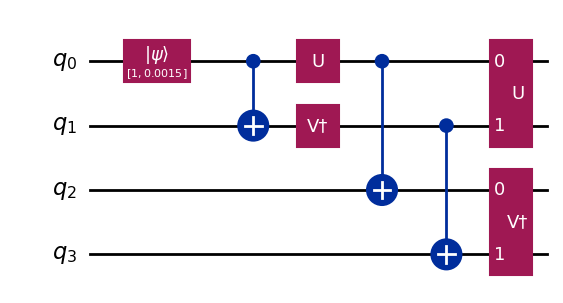

In [27]:
n_qubits = 4  # Teste com número ímpar
target_state = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)  # Estado aleatório
target_state = target_state / np.linalg.norm(target_state)  # Normalizar

# Gerar o circuito
circuit = prepare_arbitrary_state(n_qubits, target_state)

# Exibir o circuito
circuit.draw('mpl')

In [24]:
# Simular o circuito
circuit.measure_all()

sampler = Sampler()

job = sampler.run([circuit])
result = job.result()
print(f" > Counts: {result[0].data.meas.get_counts()}")

 > Counts: {'1100': 50, '1111': 43, '0110': 100, '1011': 135, '1110': 57, '1001': 163, '1101': 98, '0111': 67, '0011': 63, '0001': 33, '0000': 106, '0100': 38, '1000': 25, '0101': 18, '0010': 26, '1010': 2}


Quantum Error Correction - QEC

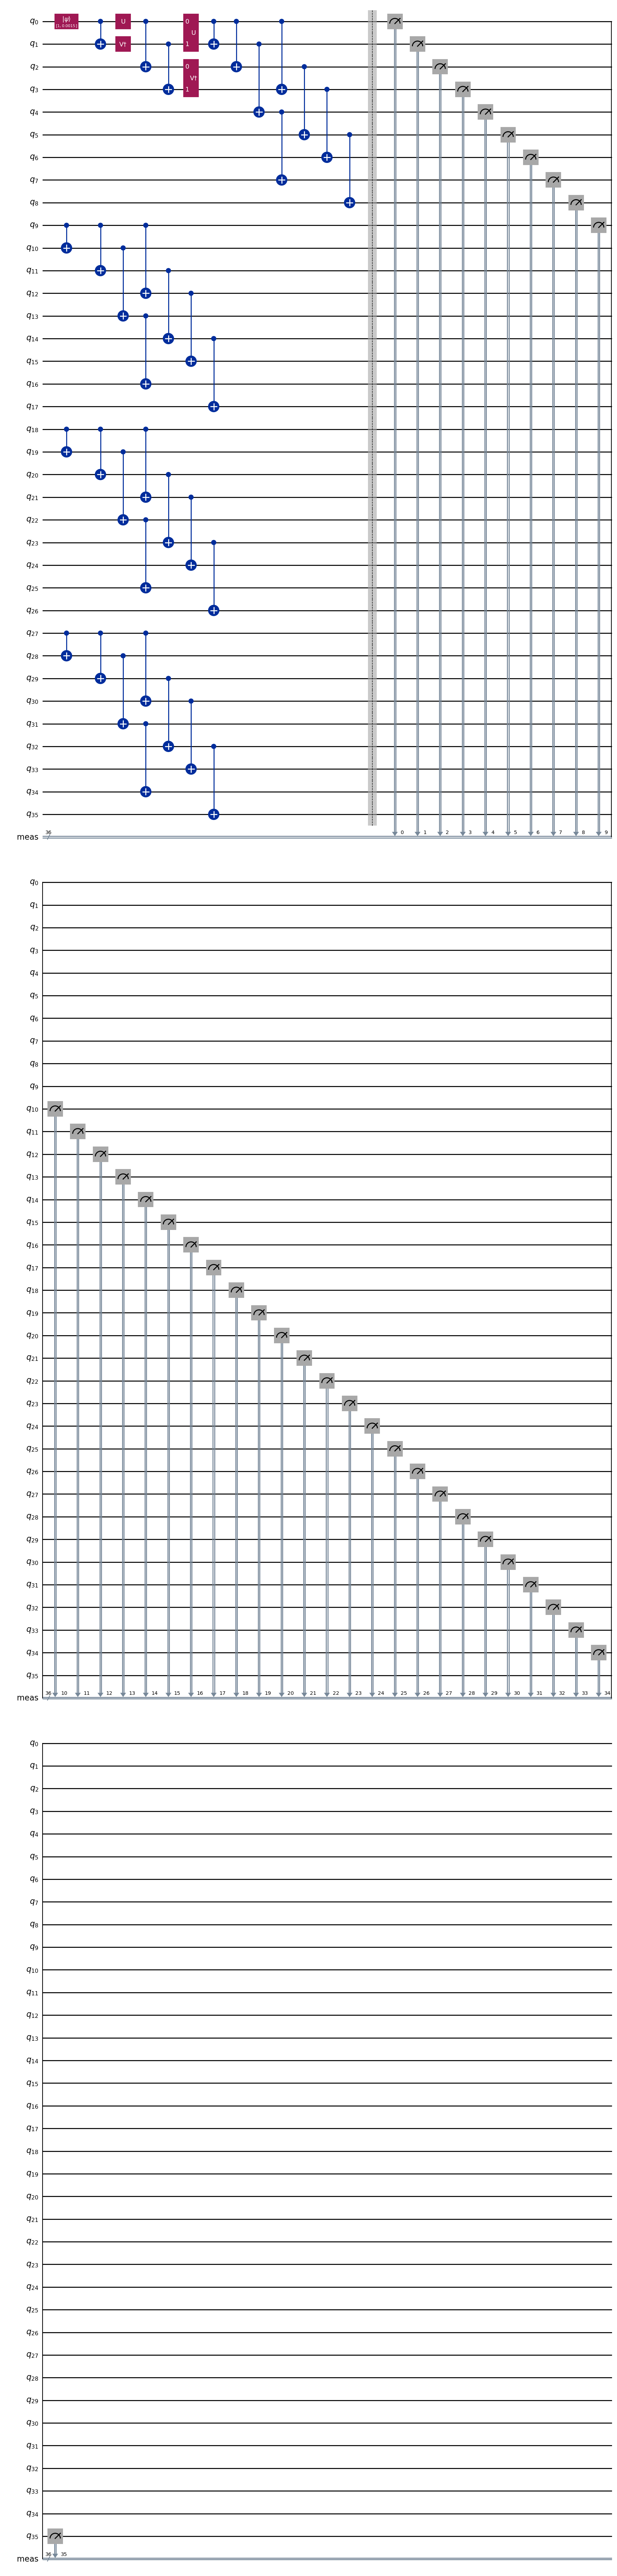

In [28]:
# Função para implementar a codificação de Shor
def apply_shor_encoding(circuit, n):
    
    shor_circuit = QuantumCircuit(n * 9)

    for i in range(n):
        # Mapeando o qubit original para 9 qubits
        logical_qubits = [i * 9 + j for j in range(9)]

        # Etapa 1: Codificação |0> -> |000>, |1> -> |111>
        shor_circuit.cx(logical_qubits[0], logical_qubits[1])
        shor_circuit.cx(logical_qubits[0], logical_qubits[2])

        # Etapa 2: Repetição nos blocos
        shor_circuit.cx(logical_qubits[0], logical_qubits[3])
        shor_circuit.cx(logical_qubits[1], logical_qubits[4])
        shor_circuit.cx(logical_qubits[2], logical_qubits[5])
        shor_circuit.cx(logical_qubits[3], logical_qubits[6])
        shor_circuit.cx(logical_qubits[4], logical_qubits[7])
        shor_circuit.cx(logical_qubits[5], logical_qubits[8])

    return shor_circuit

# Criar circuito combinado: preparação de estado e codificação de Shor
encoded_circuit = QuantumCircuit(n_qubits * 9)
encoded_circuit.compose(circuit, range(n_qubits), inplace=True)
shor_circuit = apply_shor_encoding(encoded_circuit, n_qubits)

# Adicionar codificação ao circuito final
encoded_circuit.compose(shor_circuit, range(n_qubits * 9), inplace=True)

# Medição para verificar os resultados
encoded_circuit.measure_all()

# Exibir o circuito final
encoded_circuit.draw('mpl')

In [30]:
sampler = Sampler()

job = sampler.run([encoded_circuit])
result = job.result()
print(f" > Counts: {result[0].data()['meas'].get_counts()}")

MemoryError: Unable to allocate 1.00 TiB for an array with shape (68719476736,) and data type complex128